<a href="https://colab.research.google.com/github/miladansari/protein_bert/blob/master/ProteinBERT_hemolytic_activity_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/MyDrive/protein-bert/proteinbert/


!pip install git+'https://github.com/miladansari/protein_bert.git'
!git clone https://github.com/nadavbra/shared_utils.git

#import related libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import datetime
from pandas import read_csv
%load_ext tensorboard


#reading files.

test = read_csv('/content/drive/MyDrive/protein-bert/BENCHMARK_DIR/hemolytic.test.csv',skipinitialspace=True)
train = read_csv('/content/drive/MyDrive/protein-bert/BENCHMARK_DIR/hemolytic.train.csv',skipinitialspace=True)

seqs=train['seq']
seqs_test=test['seq']

#set sequence length to 37 (the longest sequence in dataset is 35 and the model will add <start> and <end> token to the sequence.

seq_len=37
batch_size=32

from proteinbert import load_pretrained_model
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

#load pretrained model.
pretrained_model_generator, input_encoder = load_pretrained_model(local_model_dump_dir='/content/drive/MyDrive/protein-bert/proteinbert')
model = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(seq_len))

#extract local representaion (Embeddings).
X = input_encoder.encode_X(seqs, seq_len)
local_representations, global_representations= model.predict(X, batch_size = batch_size)

X_test= input_encoder.encode_X(seqs_test, seq_len)
local_representations_test, global_representations_test= model.predict(X_test, batch_size = batch_size)

#simple classifier
model_D=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = local_representations[0].shape),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

opt= tf.keras.optimizers.Adam(learning_rate=0.0001)
model_D.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])
#for tensorboard tracking ###
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print("Fit model on training data")
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.00001)
history_D = model_D.fit(local_representations, train['label'], validation_data=(local_representations_test,test['label']), batch_size=32, epochs=50,callbacks=[reduce_lr])

[Errno 2] No such file or directory: 'drive/MyDrive/protein-bert/proteinbert/'
/content/drive/MyDrive/protein-bert/proteinbert
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/miladansari/protein_bert.git to /tmp/pip-req-build-i6mqbxgp
  Running command git clone --filter=blob:none --quiet https://github.com/miladansari/protein_bert.git /tmp/pip-req-build-i6mqbxgp
  Resolved https://github.com/miladansari/protein_bert.git to commit 3a53892554067d6d32f46a1befe4013656c9d97d
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
fatal: destination path 'shared_utils' already exists and is not an empty directory.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


16/16 [==============================] - 0s 29ms/step
Fit model on training data
Epoch 1/50
102/102 [==============================] - 3s 17ms/step - loss: 0.5730 - accuracy: 0.6978 - val_loss: 0.5465 - val_accuracy: 0.7301 - lr: 1.0000e-04
Epoch 2/50
102/102 [==============================] - 1s 10ms/step - loss: 0.4933 - accuracy: 0.7729 - val_loss: 0.5193 - val_accuracy: 0.7485 - lr: 1.0000e-04
Epoch 3/50
102/102 [==============================] - 1s 12ms/step - loss: 0.4620 - accuracy: 0.8018 - val_loss: 0.5080 - val_accuracy: 0.7546 - lr: 1.0000e-04
Epoch 4/50
102/102 [==============================] - 1s 10ms/step - loss: 0.4437 - accuracy: 0.8082 - val_loss: 0.4950 - val_accuracy: 0.7710 - lr: 1.0000e-04
Epoch 5/50
102/102 [==============================] - 1s 12ms/step - loss: 0.4323 - accuracy: 0.8153 - val_loss: 0.4841 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 6/50
102/102 [==============================] - 1s 11ms/step - loss: 0.4185 - accuracy: 0.8218 - val_loss: 0.4809

In [ ]:
#%tensorboard --logdir logs/fit

In [ ]:
local_representations.shape

(3249, 37, 1562)

In [ ]:
global_representations_test.shape

(489, 15599)

In [ ]:
global_representations_test[1]

15599

In [ ]:
prediction=model_D.predict(local_representations_test[:,:,:])
predictionz=[]
for i in prediction:
  if i >0.5:
    predictionz.append(1)

  else:
    predictionz.append(0)

confusion_matrix=tf.math.confusion_matrix(labels=test['label'],predictions=predictionz,num_classes=2)
print(confusion_matrix)

16/16 [==============================] - 0s 5ms/step
tf.Tensor(
[[234  46]
 [ 52 157]], shape=(2, 2), dtype=int32)


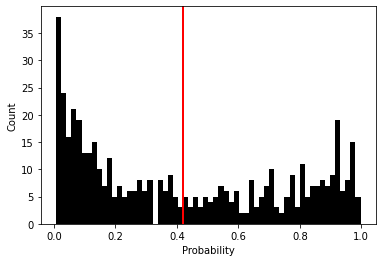

In [ ]:
#plot the histogram of predictions on test set
import matplotlib.pyplot as plt
import pandas as pd
plt.hist(prediction, bins=60, color='k')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.axvline(np.mean(prediction), color='r', linestyle='solid', linewidth=2)

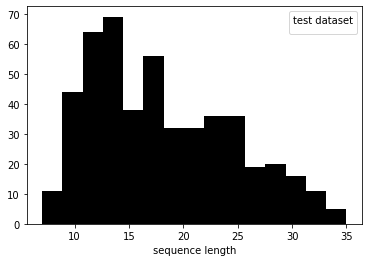

In [ ]:
pltz=[]
for i in seqs_test:
  pltz.append(len(i))
plt.hist(pltz, color='k',bins=15)
plt.xlabel('sequence length')
plt.legend(title='test dataset')

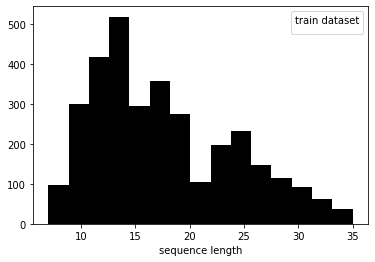

In [ ]:
pltz=[]
for i in seqs:
  pltz.append(len(i))
plt.hist(pltz, color='k',bins=15)
plt.xlabel('sequence length')
plt.legend(title='train dataset')

In [ ]:
len(train[train['label']==0])

1915

In [ ]:
#on order
import random
from collections import defaultdict

sequence = 'DEDEDEDEDEDEDEDEEDE' 
aminos = "ACDEFGHIKLMNPQRSTVWY"

mutated_dictionary = defaultdict(list)


start_pos = random.randint(0, len(sequence)-1)

pool = [sequence]

current_pos = start_pos 

for i in range(len(sequence)):
    temp_pool = []
    for seq in pool:
        temp = list(seq)
        for j in range(len(aminos)):
            temp[current_pos] = aminos[j]
            mutant = "".join(temp)
            temp_pool.append(mutant)
    X = input_encoder.encode_X(temp_pool, seq_len)
    local_representations, global_representations_test = model.predict(X, batch_size = batch_size)
    predi = model_D.predict(local_representations)
    max_index = predi.argmax()
    min_index = predi.argmin()
    max_sequence = temp_pool[max_index]
    min_sequence = temp_pool[min_index]
   
    mutated_dictionary[i].append(max_sequence)
    mutated_dictionary[i].append(min_sequence)
    
    pool = [max_sequence, min_sequence]
    current_pos = (current_pos + 1) % len(sequence)

2/2 [==============================] - 0s 6ms/step


In [ ]:
len('WWWWWWWWWWWWWWW')

15

In [ ]:
###do 100 random posi
import random
from collections import defaultdict
sequence = 'WWWWWWWWWWWWWWW' 
aminos = "ACDEFGHIKLMNPQRSTVWY"

mutated_dictionary = defaultdict(list)

# Start with the original sequence
pool = [sequence]

for i in range(30):
    temp_pool = []
    current_pos = random.randint(0,len(sequence)-1)
    for seq in pool:
        temp = list(seq)
        for j in range(len(aminos)):
            temp[current_pos] = aminos[j]
            mutant = "".join(temp)
            temp_pool.append(mutant)
    X = input_encoder.encode_X(temp_pool, seq_len)
    local_representations, global_representations_test = model.predict(X, batch_size = batch_size)
    predi = model_D.predict(local_representations)
    max_index = predi.argmax()
    min_index = predi.argmin()
    max_sequence = temp_pool[max_index]
    min_sequence = temp_pool[min_index]
    
    mutated_dictionary[i].append(max_sequence)
    mutated_dictionary[i].append(min_sequence)
    
    pool = [max_sequence, min_sequence]
  ##add plot for predictions
  ##try 10 times to see if it is the same each time
  ##plpot seq logo for 10 ,50 ,100, to show the dynamics

2/2 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 101ms/step


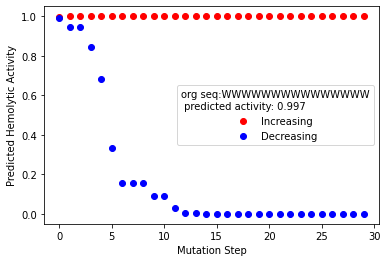

In [ ]:
#to plot changes in prediction
high_values = [v[0] for v in mutated_dictionary.values()]
low_values =  [v[1] for v in mutated_dictionary.values()]


X = input_encoder.encode_X(high_values, seq_len)
local_representations, global_representations_test = model.predict(X, batch_size = batch_size)
predix = model_D.predict(local_representations)


X = input_encoder.encode_X(low_values, seq_len)
local_representations, global_representations_test = model.predict(X, batch_size = batch_size)
predix_min = model_D.predict(local_representations)

plt.scatter(range(30),predix ,label='Increasing' ,c='r')
plt.scatter(range(30), predix_min,label='Decreasing', c='b')
plt.xlabel('Mutation Step')
plt.ylabel('Predicted Hemolytic Activity')
plt.legend(title='org seq:WWWWWWWWWWWWWWW\n predicted activity: 0.997')
plt.show()

In [ ]:
def create_files(sequence):
    for i in range(10):
        end = (i + 1) * 100 if i < 9 else len(sequence)
        filename = f"file_{i+1}.txt"
        with open(filename, "w") as file:
            for j in range(end):
                file.write(f"{sequence[j]}\n")


In [ ]:
create_files(low_values)


/content/drive/MyDrive/Seq_logo


In [ ]:
%cd Seq_logo/


/content/drive/MyDrive/Seq_logo


In [ ]:
with open("max_30.txt", "w") as f:
  for i in mutated_dictionary.values():
    f.write(i[0])
    f.write("\n")

In [ ]:
#for min
with open("min_30.txt", "w") as f:
  for i in mutated_dictionary.values():
    f.write(i[1])
    f.write("\n")

1/1 [==============================] - 0s 20ms/step
[[0.4441451]]


In [ ]:

sequence='QQQQQQQQQQQQQQQ' 

aminos=['A','G','I','L','P','V','F','W','Y','D','E','R','H','K','S','T','C','M','N','Q']  



mutated_1=[]

temp=list(sequence)
for i in range(len(temp)):
  for j in aminos:
      temp=list(sequence)
      temp[i]=j
      mutated_1.append("".join(temp))
X= input_encoder.encode_X(mutated_1, seq_len)
local_representations, global_representations_test= model.predict(X, batch_size = batch_size)

p=model_D.predict(local_representations)


10/10 [==============================] - 0s 9ms/step


In [ ]:

len(sequence)

15

In [ ]:
#prediction on original sequence
picked=[sequence]

X= input_encoder.encode_X(picked, seq_len)
local_representations, global_representations_test= model.predict(X, batch_size = batch_size)

pred=model_D.predict(local_representations)
print(pred)
wt_pred=pred[0][0]

1/1 [==============================] - 0s 23ms/step
[[0.00168882]]


<ipython-input-147-16664b728470>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.axes.set_xticklabels(aminos)
<ipython-input-147-16664b728470>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.axes.set_yticklabels(list(sequence))


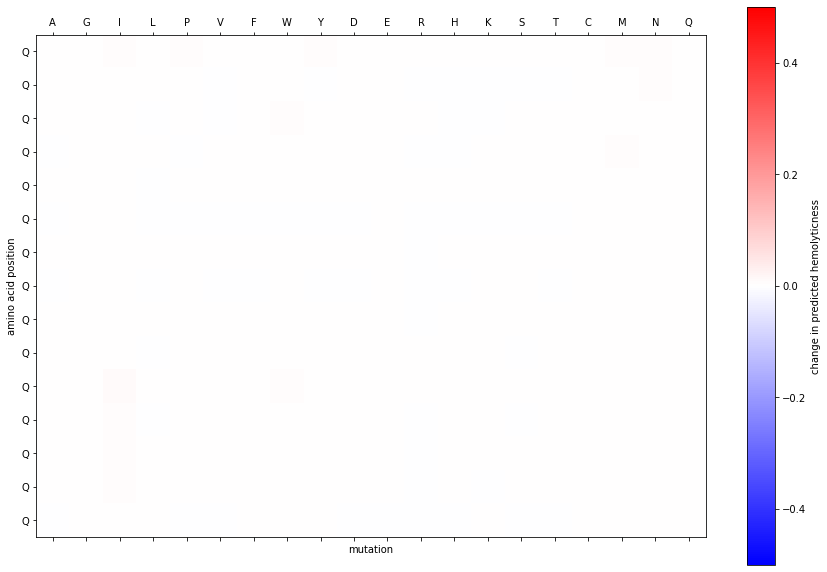

In [ ]:
#plot the result on matshow
p=np.squeeze(p)
m=p.reshape((len(sequence),20))


plt.figure(figsize=(15,10))
cax=plt.matshow(m-wt_pred, vmin=-0.5, vmax=0.5,cmap='bwr',fignum=1)
cax.axes.set_xticklabels(aminos)
cax.axes.set_xticks(np.arange(len(aminos)))

cax.axes.set_yticklabels(list(sequence))
cax.axes.set_yticks(np.arange(len(sequence)))


plt.xlabel("mutation")
plt.ylabel("amino acid position")
plt.colorbar(label='change in predicted hemolyticness')
plt.show() 


In [ ]:
#for low to high

In [ ]:
aminos=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] 


prediction=prediction.squeeze()
prediction_list=(list(prediction))

low_sequences=[]
for i in prediction:
  if  i <0.4:

    index=prediction_list.index(i)
    low_sequences.append(seqs_test[index])

highest_value_mutated=[]


for k in low_sequences:
  mutated=[]
  position=0
  amino_acid=0
  string=str(k)
  temp=list(string)

  for i in range(len(temp)):
    for j in range(len(aminos)+1):

      if amino_acid <= len(aminos)-1:
        temp[position]=aminos[amino_acid]
        stri = "".join(temp)  
        mutated.append(stri)
        amino_acid+=1
      else:
        position+=1
        amino_acid=0
        temp=list(string)
        pass

  X= input_encoder.encode_X(mutated, seq_len)
  local_representations, global_representations_test= model.predict(X, batch_size = batch_size)
  pre=model_D.predict(local_representations)

  pre=pre.squeeze()
  p_list=(list(pre))
  highest_value_mutated.append(mutated[p_list.index(max(p_list))])
  #lowest_value_mutated.append(mutated[p_list.index(min(p_list))])



In [ ]:
high_value_comparison=dict(zip(low_sequences, highest_value_mutated))

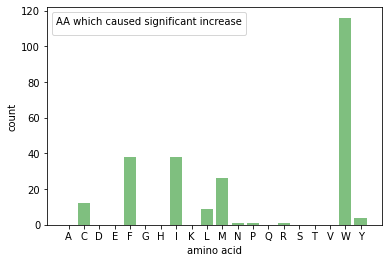

In [ ]:
#that amino acid which caused the highest increase

increasing_AA=[]
positionz=[]
for k ,v in high_value_comparison.items():
  for i in range(len(k)):
    if k[i] != v[i]:
      increasing_AA.append(v[i])
      positionz.append(i)
count_per_aminoacid_increase=[]
for i in aminos:
  count_per_aminoacid_increase.append(increasing_AA.count(i))


plt.bar(aminos,count_per_aminoacid_increase, alpha=0.5, color='g')  
plt.xlabel('amino acid')
plt.ylabel('count')
plt.legend(title='AA which caused significant increase')

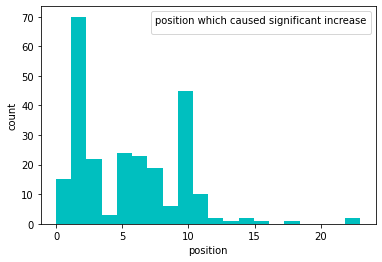

In [ ]:
plt.hist(positionz,bins=20,color='c')
plt.xlabel('position')
plt.ylabel('count')
plt.legend(title='position which caused significant increase')

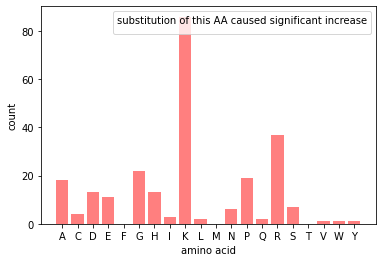

In [ ]:
#that amino acid which its substitution caused the highest increase
increasing_AA=[]
for k ,v in high_value_comparison.items():
  for i in range(len(k)):
    if k[i] != v[i]:
      increasing_AA.append(k[i])
count_per_aminoacid_increase=[]
for i in aminos:
  count_per_aminoacid_increase.append(increasing_AA.count(i))


plt.bar(aminos,count_per_aminoacid_increase, alpha=0.5, color='r')  
plt.xlabel('amino acid')
plt.ylabel('count')
plt.legend(title='substitution of this AA caused significant increase')

In [ ]:
#for high to low

prediction=prediction.squeeze()
prediction_list=(list(prediction))

high_sequences=[]
for i in prediction:
  if 0.6< i :

    index=prediction_list.index(i)
    high_sequences.append(seqs_test[index])

# highest_value_mutated=[]
lowest_value_mutated=[]

for k in high_sequences:
  mutated=[]
  position=0
  amino_acid=0
  string=str(k)
  temp=list(string)

  for i in range(len(temp)):
    for j in range(len(aminos)+1):

      if amino_acid <= len(aminos)-1:
        temp[position]=aminos[amino_acid]
        stri = "".join(temp)  
        mutated.append(stri)
        amino_acid+=1
      else:
        position+=1
        amino_acid=0
        temp=list(string)
        pass

  #after each sequence get those mutated variants with highest and lowest value
  X= input_encoder.encode_X(mutated, seq_len)
  local_representations, global_representations_test= model.predict(X, batch_size = batch_size)
  pre=model_D.predict(local_representations)

  pre=pre.squeeze()
  p_list=(list(pre))
  #highest_value_mutated.append(mutated[p_list.index(max(p_list))])
  lowest_value_mutated.append(mutated[p_list.index(min(p_list))])


In [ ]:
low_value_comparison=dict(zip(high_sequences, lowest_value_mutated))

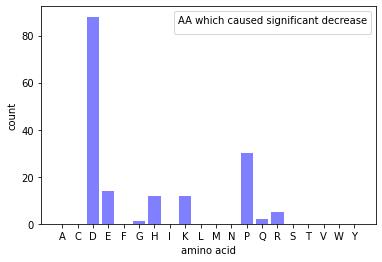

In [ ]:
#that amino acid which caused the highest decrease
positionz=[]
decreasing_AA=[]
for k ,v in low_value_comparison.items():
  for i in range(len(k)):
    if k[i] != v[i]:
      decreasing_AA.append(v[i])
      positionz.append(i)
count_per_aminoacid_decrease=[]
for i in aminos:
  count_per_aminoacid_decrease.append(decreasing_AA.count(i))


plt.bar(aminos,count_per_aminoacid_decrease,alpha=0.5,color='b')
plt.xlabel('amino acid')
plt.ylabel('count')
plt.legend(title='AA which caused significant decrease')

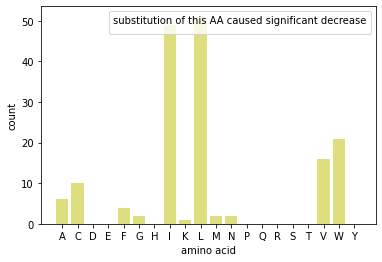

In [ ]:
#that amino acid which it substitution caused the highest decrease

decreasing_AA=[]
for k ,v in low_value_comparison.items():
  for i in range(len(k)):
    if k[i] != v[i]:
      decreasing_AA.append(k[i])
count_per_aminoacid_decrease=[]
for i in aminos:
  count_per_aminoacid_decrease.append(decreasing_AA.count(i))


plt.bar(aminos,count_per_aminoacid_decrease,alpha=0.5,color='y')
plt.xlabel('amino acid')
plt.ylabel('count')
plt.legend(title='substitution of this AA caused significant decrease')

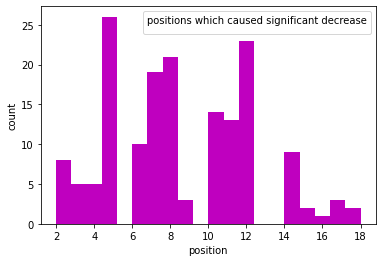

In [ ]:
plt.hist(positionz,bins=20,color='m')
plt.xlabel('position')
plt.ylabel('count')
plt.legend(title='positions which caused significant decrease')

In [ ]:
!pip install biopython
from Bio.SeqUtils.ProtParam import ProteinAnalysis as PA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.0 MB/s eta 0:00:00


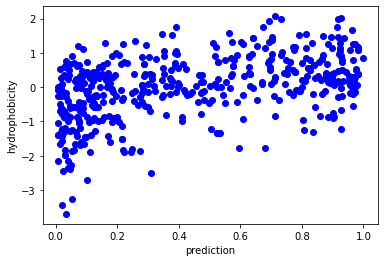

In [ ]:
#for all test sequences
hydrophobicity_on_dataset=[]
for i in test['seq']:
  protein=PA(i)
  hydrophobicity_on_dataset.append(protein.gravy())

plt.scatter(prediction ,hydrophobicity_on_dataset, c='b')
plt.xlabel('prediction')
plt.ylabel('hydrophobicity')
plt.show()

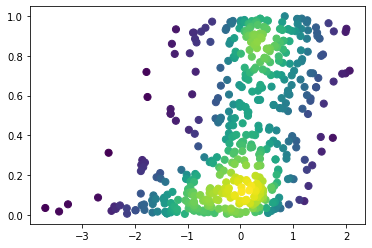

In [ ]:
############try to draw a line in the center of density so show the weigted mean is maybe

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

prediction=np.squeeze(prediction)
x=np.array(hydrophobicity_on_dataset)
y=np.array(prediction)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.show()
#change axis

In [ ]:
prediction=prediction.squeeze()
prediction_list=(list(prediction))
dictionary=dict(zip(test['seq'], prediction_list))

high_value_sequences=[]
low_value_sequences=[]
for k, v in dictionary.items():
  if float(v) > 0.99:
    high_value_sequences.append(k)    
  elif float(v) < 0.01:
    low_value_sequences.append(k)


In [ ]:
len(high_value_sequences)

1

In [ ]:
len(low_value_sequences)

8

In [ ]:
#prediction is a variable that has the predicted value for all the test set
flexibility=[]
hydrophobicity=[]
aromaticity=[]
charge=[]
for i in test['seq']:
  protein=PA(i)
  #flexibility.append(protein.flexibility())
  hydrophobicity.append(protein.gravy())
  aromaticity.append(protein.aromaticity())
  charge.append(protein.charge_at_pH(pH=7.4))



import pandas as pd
prediction=prediction.squeeze()
prediction_list=(list(prediction))




dataframe=pd.DataFrame({'Prediction': prediction_list ,
                        'Ground truth': test['label'],
                        'Hydrophobicity': hydrophobicity,
                        'Aromaticity': aromaticity,
                        'Charge': charge})


In [ ]:
dataframe

,Prediction,Ground truth,Hydrophobicity,Aromaticity,Charge
0,0.816624,1,1.146154,0.153846,1.552442
1,0.399595,0,-0.800000,0.357143,5.549861
2,0.288548,0,0.713333,0.066667,2.549936
3,0.580604,1,-1.762500,0.187500,6.557277
4,0.709711,1,0.178571,0.071429,1.551057
...,...,...,...,...,...
484,0.751294,1,-0.231818,0.136364,5.552316
485,0.909006,1,1.138462,0.153846,0.554947
486,0.029902,0,-2.445455,0.272727,5.554822
487,0.684848,1,-0.372222,0.055556,6.581476


In [ ]:
#false positive
dataframe[dataframe['Ground truth']==0].query('Prediction < 0.5')

,Prediction,Ground truth,Hydrophobicity,Aromaticity,Charge
1,0.399595,0,-0.800000,0.357143,5.549861
2,0.288548,0,0.713333,0.066667,2.549936
6,0.108958,0,0.111111,0.000000,3.557352
7,0.126865,0,0.020000,0.000000,4.537506
8,0.085987,0,-0.570000,0.100000,4.508321
...,...,...,...,...,...
475,0.157396,0,-0.880000,0.100000,4.544925
479,0.011612,0,-1.393750,0.093750,3.588451
481,0.341255,0,0.035294,0.176471,6.539914
486,0.029902,0,-2.445455,0.272727,5.554822


In [ ]:
test['seq'][349]

'FRIRVRVKWKLFKKI'

In [ ]:
test['label'][349]

0

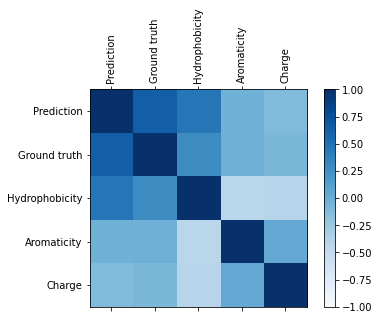

In [ ]:
corr = dataframe.corr()
fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.matshow(corr,cmap='Blues', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(dataframe.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(dataframe.columns)
ax.set_yticklabels(dataframe.columns)
plt.show()

In [ ]:
corr

,prediction,ground truth,hydrophobicity,aromaticity,charge
prediction,1.000000,0.634129,0.463790,-0.032761,-0.108834
ground truth,0.634129,1.000000,0.284078,-0.017800,-0.082506
hydrophobicity,0.463790,0.284078,1.000000,-0.426520,-0.411486
aromaticity,-0.032761,-0.017800,-0.426520,1.000000,0.043961
charge,-0.108834,-0.082506,-0.411486,0.043961,1.000000


In [ ]:
# Install TF-DF
!pip install tensorflow tensorflow_decision_forests

# Load TF-DF
import tensorflow_decision_forests as tfdf
import pandas as pd

# Load a dataset in a Pandas dataframe.
train_df = pd.read_csv("project/train.csv")
test_df = pd.read_csv("project/test.csv")

# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="my_label")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="my_label")

# Train a Random Forest model.
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

# Summary of the model structure.
model.summary()

# Evaluate the model.
model.evaluate(test_ds)

# Export the model to a SavedModel.
model.save("project/model")